In [1]:
import qiskit
import qc_grader

print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.12


In [3]:

# Import common packages first
import numpy as np
from math import comb

import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# Import qiskit ecosystems
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab3_ex1, 
    grade_lab3_ex2, 
    grade_lab3_ex3,
    grade_lab3_ex4,
    grade_lab3_ex5
)

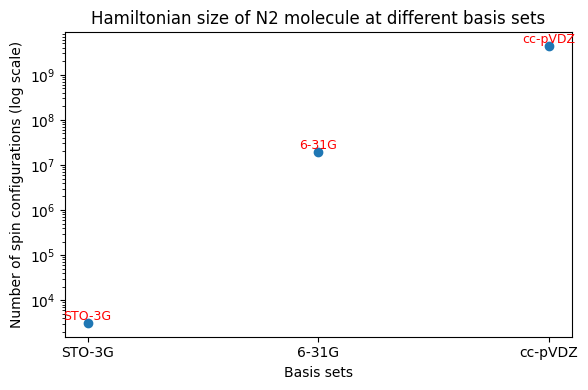

In [4]:
# Number of possible spin configurations
# Example: N2 molecule in STO-3G, 6-31G, and cc-pVDZ basis sets
# 14 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate total electron configurations for each basis set
y1 = comb(8, 5) * comb(8, 5)       # STO-3G
y2 = comb(16, 5) * comb(16, 5)     # 6-31G
y3 = comb(26, 5) * comb(26, 5)     # cc-pVDZ

# Data
y = [y1, y2, y3]
x = list(range(len(y)))
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

# Plot with logarithmic y-scale
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o')

plt.yscale('log')
plt.xticks(x, labels)
plt.xlabel('Basis sets')
plt.ylabel('Number of spin configurations (log scale)')
plt.title('Hamiltonian size of N2 molecule at different basis sets')

# Add labels above points
for i in range(len(x)):
    plt.text(x[i], y[i], f'{labels[i]}', fontsize=9, ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

In [5]:
# Exercise 1: Number of possible spin configurations
# Example: O2 molecule in 6-31G basis
# 16 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate all valid electron configurations
# Hint: This is a combinatorial problem. You can calculate by hand and provide the answer or use the math.comb() method below.

# ---- TODO : Task 1 ---
### Provide your code below to calculate the total configurations

α_config = comb(16,7)
β_config = comb(16,5)
total_config = (α_config)*(β_config)
# --- End of TODO ---

print(f"Total physical configurations for O2 in the given basis : {α_config:} x {β_config:} = {total_config}")

Total physical configurations for O2 in the given basis : 11440 x 4368 = 49969920


In [12]:
grade_lab3_ex1(total_config) # Expected result type: integer


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [5]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

KeyboardInterrupt: 

In [7]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.2045891221988307


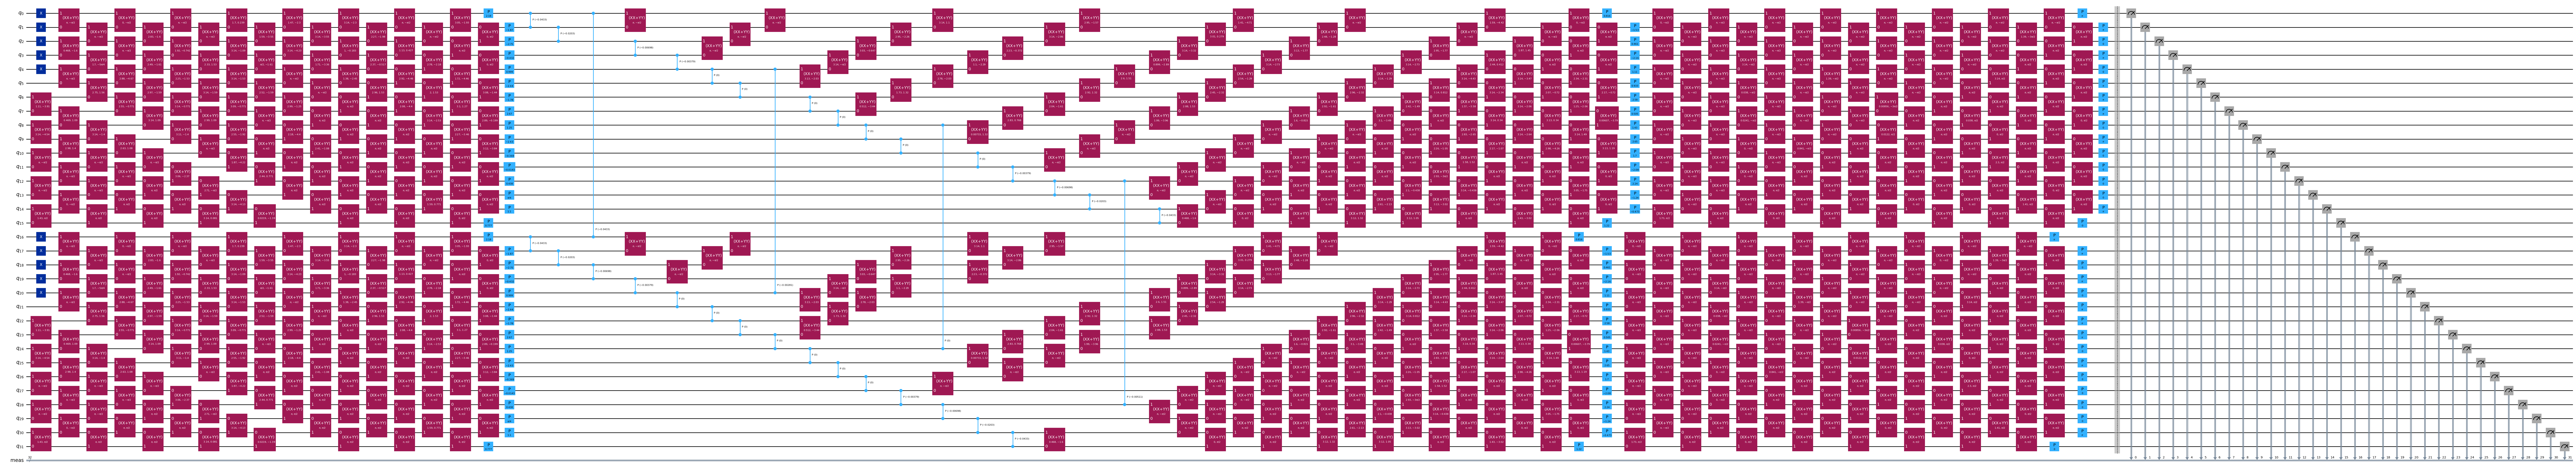

In [8]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

circuit.decompose().decompose().draw("mpl", fold =-1)

In [10]:
service = QiskitRuntimeService(name="qgss-2025") 
backend = service.backend("ibm_brisbane")

In [13]:
spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82] 
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73] 
initial_layout = spin_a_layout + spin_b_layout 
pass_manager = generate_preset_pass_manager( optimization_level=3, backend=backend, initial_layout=initial_layout ) 
# We will use the circuit generated by this pass manager for hardware execution 
pass_manager.pre_init = ffsim.qiskit.PRE_INIT 
isa_circuit = pass_manager.run(circuit) 
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/ pre-init passes): OrderedDict([('rz', 2462), ('sx', 2103), ('ecr', 730), ('x', 80), ('measure', 32), ('barrier', 1)])


In [ ]:
%%time
# SQD options
energy_tol = 1e-3  
occupancies_tol = 1e-3 
max_iterations = 5

# Eigenstate solver options
num_batches = 5
samples_per_batch = 50
symmetrize_spin = True 
carryover_threshold = 1e-4 
max_cycle = 200
rng = np.random.default_rng(24)


# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)


# List to capture intermediate results
result_history = [] 

def callback(results: list[SCIResult]): 
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

In [ ]:
def plot_energy_and_occupancy(result_history, exact_energy):

    # Data for energies plot
    x1 = range(len(result_history))
    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    e_diff = [abs(e - exact_energy) for e in min_e]
    yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
    
    # Chemical accuracy (+/- 1 milli-Hartree)
    chem_accuracy = 0.001
    
    # Data for avg spatial orbital occupancy
    y2 = np.sum(result.orbital_occupancies, axis=0)
    x2 = range(len(y2))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot energies
    axs[0].plot(x1, e_diff, label="energy error", marker="o")
    axs[0].set_xticks(x1)
    axs[0].set_xticklabels(x1)
    axs[0].set_yticks(yt1)
    axs[0].set_yticklabels(yt1)
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-4)
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
    axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
    axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
    axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
    axs[0].legend()
    
    # Plot orbital occupancy
    axs[1].bar(x2, y2, width=0.8)
    axs[1].set_xticks(x2)
    axs[1].set_xticklabels(x2)
    axs[1].set_title("Avg Occupancy per Spatial Orbital")
    axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
    axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
    
    print(f"Exact energy: {exact_energy:.5f} Ha")
    print(f"SQD energy: {min_e[-1]:.5f} Ha")
    print(f"Absolute error: {e_diff[-1]:.5f} Ha")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_energy_and_occupancy(result_history, exact_energy)


In [16]:
n = [0.007, 0.029, 0.029, 0.995, 0.976, 0.976, 0.993, 0.997, 0.007, 0.029, 0.029, 0.995,0.976, 0.976, 0.993, 0.997]

x = [1, 0, 0, 0,  1, 0, 1, 1,  1, 0, 1, 1,  1, 1, 0, 0]

In [17]:
x = np.array(x)
n = np.array(n)

# ---- TODO : Task 2 ---

# Divide into alpha spin and beta spin

x_alpha = x[8:]
x_beta = x[ :8]

# probability of flipping
y = np.abs(x - n)
y_alpha = y[8:]
y_beta =y[:8]

# In this case, one more beta particle is needed, so set y_beta[i] to 0 if x_beta[i] is already 1. 
for i in range(len(y_beta)):
    if x_beta[i] == 1:
        y_beta[i] = 0


# --- End of TODO ---
print(x_beta)
print(x_alpha)

print(y_beta)

[1 0 0 0 1 0 1 1]
[1 0 1 1 1 1 0 0]
[0.    0.029 0.029 0.995 0.    0.976 0.    0.   ]


In [18]:
h = 5/8
delta = 0.01
w = np.zeros(len(y_beta))

# find the maximum w
# ---- TODO : Task 2 ---
for i in range(len(y_beta)):
    y = y_beta[i]
    if y <= h:
        w[i] = delta * (y / h)
    else:
        w[i] = delta + (1 - delta) * ((y - h) / (1 - h))
max_index = np.argmax(w)
max_w = w[max_index]

# --- End of TODO ---
print(max_index, max_w)

3 0.9868


In [19]:
# Flip the bit of the index with the largest w
# ---- TODO : Task 2 ---
for i in range(len(y_beta)):
    if i == max_index:
        x_beta[i] = 1 - x_beta[i]


x = np.concatenate([x_beta, x_alpha])
corrected_x = x.tolist()
# --- End of TODO ---
print(corrected_x)

[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]


In [11]:
# Submit your answer using following code

grade_lab3_ex2(corrected_x) # Expected result type: list

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [28]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    # ---- TODO : Task 3 ---
    basis= "cc-pvdz",
    # --- End of TODO ---
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

print(num_orbitals)

converged SCF energy = -108.929838385609
26


In [29]:
# ---- TODO : Task 3 ---
n_qubits = 58###
# --- End of TODO ---

In [32]:
grade_lab3_ex3(n_qubits) # Expected result type: integer


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [6]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService(name="qgss-2025")
# backend = service.backend('ibm_torino') 
#backend_target = backend.target

In [4]:
backend = service.backend('ibm_torino') 


In [5]:
import qiskit
print(f'Qiskit: {qiskit.__version__}')


Qiskit: 2.1.1


In [6]:
with open("backend_target_v21.pkl", "rb") as f:
   backend_target = pickle.load(f)    

In [7]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_CZGATE_ERROR_THRESHOLD = 0.1
backend_num_qubits = 133

# ---- TODO : Task 4 ---

bad_readout_qubits = []
bad_czgate_edges = []

#bad_readout_qubits = backend_target["measure"][(0,)]
for i in range(backend_num_qubits): 
    if backend_target["measure"][(i,)].error >= BAD_READOUT_ERROR_THRESHOLD:
        bad_readout_qubits.append(i)

for (q0, q1), cz_instr in backend_target["cz"].items():
    if cz_instr.error is not None and cz_instr.error >= BAD_CZGATE_ERROR_THRESHOLD:
        bad_czgate_edges.append((q0, q1))
# --- End of TODO ---
print("Bad readout qubits:", bad_readout_qubits)
print("Bad CZ gates:", bad_czgate_edges)

Bad readout qubits: [12, 53, 115, 126, 131]
Bad CZ gates: [(100, 101), (101, 100)]


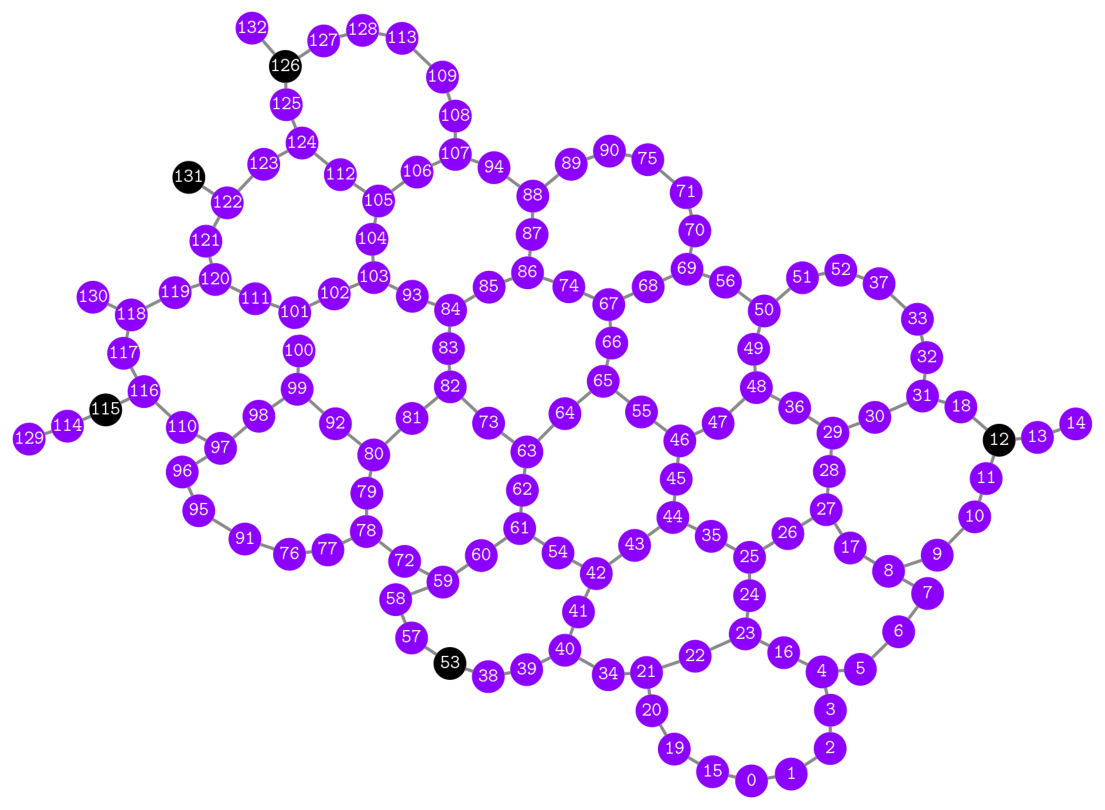

In [8]:
qubit_color = []
for i in range(backend_num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    else:
        qubit_color.append("#8c00ff") #purple
line_color = []
for e in backend_target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff") #white
    else:
        line_color.append("#888888") #gray
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(14,14))


In [9]:
good_qubits = [q for q in range(backend.num_qubits)
               if q not in bad_readout_qubits and q not in bad_czgate_edges]


In [23]:
# select the initial layout
# ---- TODO : Task 4 ---
spin_a_layout = [2,3,4,16,23,24,25,35,44,45,46,55,65,66,67,74,86,87,88,94,107,108,109,113,128,127]
spin_b_layout = [0,15, 19,20,21,34,40,41,42,54,61,62,63,73,82,83,84,93,103,104,105,112,124,123,122,121]
# --- End of TODO ---
initial_layout = spin_a_layout + spin_b_layout

In [24]:
len(spin_a_layout)

26

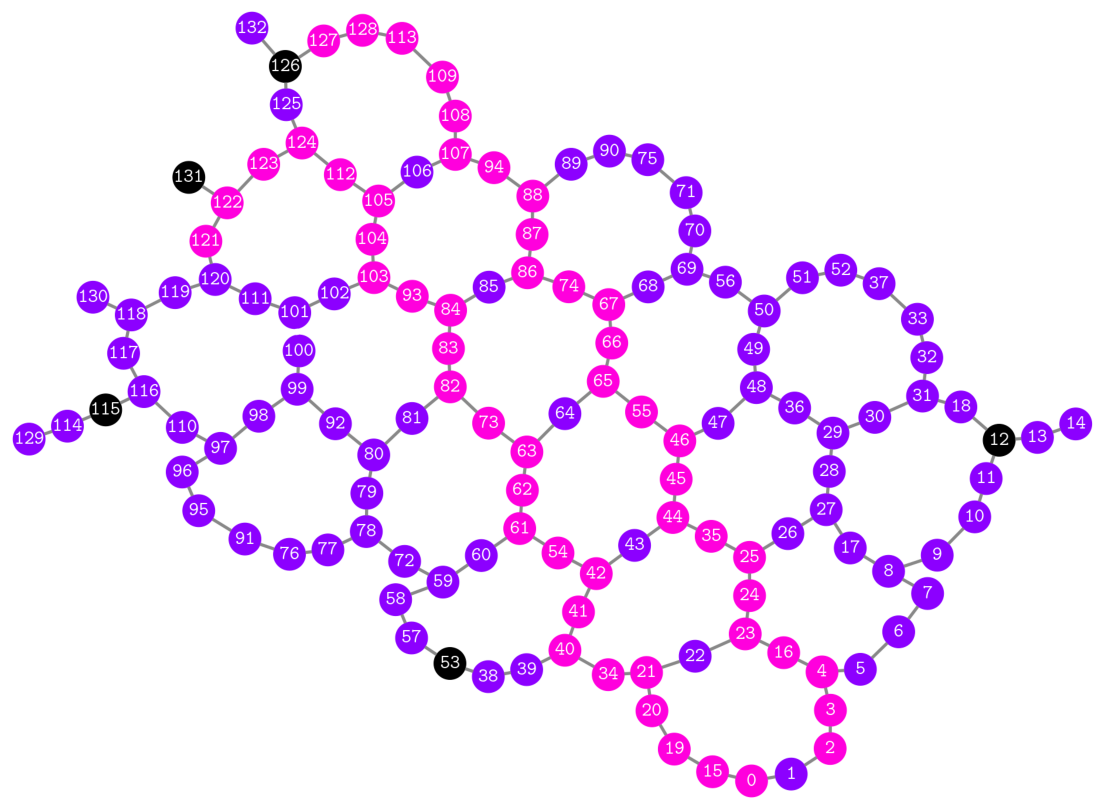

In [25]:
qubit_color = []
for i in range(backend_num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000") #black
    elif i in initial_layout:
        qubit_color.append("#ff00dd") #pink
    else:
        qubit_color.append("#8c00ff") #purple
line_color = []
for e in backend_target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff") #white
    else:
        line_color.append("#888888") #gray
plot_gate_map(backend, qubit_color=qubit_color, line_color=line_color, qubit_size=50, font_size=25, figsize=(14,14))

In [26]:

# Submit your answer using following code

grade_lab3_ex4(initial_layout) # Expected result type: lists

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [42]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

n_reps = 1
# ---- TODO : Task 5 ---
#alpha_alpha_indices = ### input your code here ###
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)] + [(p, p + 2) for p in range(num_orbitals - 2)]

# --- End of TODO ---
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()
circuit.decompose().decompose().draw("mpl", fold=-1)

E(CCSD) = -109.2177884185544  E_corr = -0.2879500329450035


In [43]:
grade_lab3_ex5(alpha_alpha_indices) # Expected result type: list[tuple[int, int]]


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [44]:
# Check your submission status with the code below
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2216 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1668 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 937 participants have completed this lab
Lab 3: 5/5 exercises completed (100%)
    ✅ 666 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 438 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 3 participants have completed this lab
